<a href="https://colab.research.google.com/github/komal029/LipRead/blob/main/LipSync.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.0 Install and Import Dependencies


In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow
#opencv- preprocess the data
#imageio- to create gifs, to see the frames stacked together
#gdown- to download the data set
#tensorflow- to build the DNN

In [ ]:
!pip list

In [ ]:
#Importing Dependencies
import os #to traverse through the file system
import cv2 #to import opencv that will laod and preprocess the data
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio #from numpy array to gif

#Settin up the GPU

In [ ]:
physical_device = tf.config.list_physical_devices('GPU')

In [ ]:
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

#1.1 Build Data Loading Function

In [ ]:
def load_video(path:str) -> List[float]:

  cap = cv2.VideoCapture(path)
  frames  = []
  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[199:236, 80:220,:])
  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames - mean), tf.float32) / std


NameError: name 'List' is not defined

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
#Tokenizing the vocabulary
from tensorflow import keras

char_to_num = keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size={char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size=40)


In [ ]:
file_path = "/content/drive/MyDrive/LipRead/data"

In [ ]:
def load_alignments(path: str) -> List[str]:
    tokens = []  # Initialize tokens as an empty list
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens.extend([' ', line[2]])  # Append to the list
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]

    # Use drive_folder_path as the base path
    video_path = os.path.join(file_path, 's1', f'{file_name}.mpg')
    alignment_path = os.path.join(file_path, 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [ ]:
test_path = "/content/drive/MyDrive/LipRead/data/s1/bbaf2n.mpg"

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

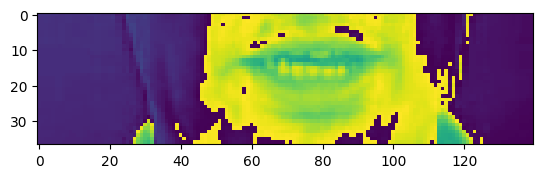

In [ ]:
plt.imshow(frames[50])

In [ ]:
tf.strings.reduce_join(([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]))

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

# 1.2 Create Data Pipeline


In [ ]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/LipRead/data/s1/*mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
train = data.take(450)
test = data.skip(450)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
test = data.as_numpy_iterator()

In [ ]:
val = test.next(); val[0]

array([[[[[1.5223012 ],
          [1.5223012 ],
          [1.5223012 ],
          ...,
          [0.49563295],
          [0.49563295],
          [0.49563295]],

         [[1.4868988 ],
          [1.4868988 ],
          [1.4514965 ],
          ...,
          [0.4602306 ],
          [0.4602306 ],
          [0.4602306 ]],

         [[1.4868988 ],
          [1.4868988 ],
          [1.4514965 ],
          ...,
          [0.4602306 ],
          [0.4602306 ],
          [0.4602306 ]],

         ...,

         [[1.0974729 ],
          [1.0974729 ],
          [1.0974729 ],
          ...,
          [0.21241412],
          [0.21241412],
          [0.21241412]],

         [[1.0974729 ],
          [1.0974729 ],
          [1.0974729 ],
          ...,
          [0.17701177],
          [0.17701177],
          [0.17701177]],

         [[1.0974729 ],
          [1.0974729 ],
          [1.0974729 ],
          ...,
          [0.17701177],
          [0.17701177],
          [0.17701177]]],


        [[[1.4514

In [ ]:
import imageio
from PIL import Image
import numpy as np

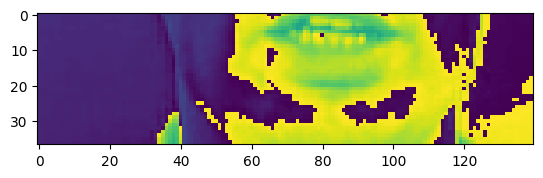

In [ ]:
# 0:videos, 0: 1st video out of the bacth, 0: return the first frame in the video
plt.imshow(val[0][1][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by z six please'>

# Design the Deep Neural Network

In [ ]:
# using CTC Connectionist Temporal Classification as loss function

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [ ]:
#Neural Network
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 37, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer = 'Orthogonal', return_sequences = True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer = 'Orthogonal', return_sequences = True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation = 'softmax'))

In [ ]:
char_to_num.vocab_size()

40

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 37, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 37, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 18, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 18, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 18, 70, 256)   0         
                                                        

In [ ]:
print(val[0].shape)

(2, 75, 37, 140, 1)


In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 24s 24s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'llllllllllllllllllllllllllllllllllllllllllllddttttttttttlllttttttttttttttjj'>

In [ ]:
yhat[0].shape

(75, 41)

In [ ]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([11, 11, 11, 11, 11, 11, 11, 11, 32, 32, 32, 32, 32, 32, 32, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11,  0,  0,  0,  0,  0,  0])>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'kkkkkkkk3333333kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk'>

In [ ]:
model.input_shape

(None, 75, 37, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# Setup Training Options and Train

In [ ]:
#defining learning rate scheduler
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

  # **Calculate input_length directly using y_pred:**
  input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")

  # **Calculate and assign label_length before using it:**
  label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

  input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
  label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
  return loss


In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
  def __init__(self, dataset) -> None:
    self.dataset = dataset.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs=None) -> None:
    data = self.dataset.next()
    yhat = self.model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
    for x in range(len(yhat)):
          print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
          print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
          print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('Models', 'checkpoint'), monitor='loss', save_weights_only = True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(data, validation_data = test, epochs= 80, callbacks= [checkpoint_callback , schedule_callback, example_callback])

# Make a Prediction